In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import re
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
import spacy
import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

1. Download the data
   - concatenate the data
   - convert the 'Date' variable from object to timestamp
2. Change the variable names
3. Remove rows missing keyword values
4. Remove rows with more than one keyword value
5. Remove tweets containing url links
6. Reset index
7. Unfold contractions so that there is no words with apostrophes
8. Filter data by tweet length

#### 1. Download the data

In [2]:
tweets_1=pd.read_csv('tweets_02_03_01.csv')
tweets_2=pd.read_csv('tweets_16_02.csv')
tweets_3=pd.read_csv('tweets_2.csv')
tweets_4=pd.read_csv('tweets_21_02.csv')
tweets_5=pd.read_csv('tweets_21_2_4.csv')
tweets_6=pd.read_csv('tweets_21_2_sec.csv')
tweets_7=pd.read_csv('tweets_22_02.csv')
tweets_8=pd.read_csv('tweets_22_2_2.csv')
tweets_9=pd.read_csv('tweets_22_2_3.csv')
tweets_10=pd.read_csv('tweets_24_02_01.csv')
tweets_11=pd.read_csv('tweets_26_2.csv')
tweets_12=pd.read_csv('tweets_27_2.csv')
tweets_13=pd.read_csv('tweets_28_2_1.csv')
tweets_14=pd.read_csv('tweets_28_2_2.csv')
tweets_15=pd.read_csv('tweets_28_2_3.csv')
tweets_16=pd.read_csv('tweets_28_2_4.csv')
tweets_17=pd.read_csv('tweets_1.csv')
tweets_18=pd.read_csv('tweets_02_03_02.csv')
tweets_19=pd.read_csv('tweets_02_03_01.csv')
tweets_20=pd.read_csv('tweets_03_03_01.csv')
tweets_21=pd.read_csv('tweets_03_03_02.csv')
tweets_22=pd.read_csv('tweets_03_03_03.csv')
tweets_23=pd.read_csv('tweets_03_03_04.csv')
tweets_24=pd.read_csv('tweets_04_03_01.csv')
tweets_25=pd.read_csv('tweets_04_03_02.csv')
tweets_26=pd.read_csv('tweets_04_03_03.csv')
tweets_27=pd.read_csv('tweets_04_03_04.csv')
tweets_28=pd.read_csv('tweets_05_03_01.csv')
tweets_29=pd.read_csv('tweets_05_03_02.csv')
tweets_30=pd.read_csv('tweets_05_03_03.csv')
tweets_31=pd.read_csv('tweets_05_03_04.csv')
tweets_32=pd.read_csv('tweets_05_03_04.csv')

In [3]:
tweets = pd.concat([tweets_1,tweets_2,tweets_3,tweets_4, tweets_5,tweets_6,tweets_7,tweets_8,tweets_9,tweets_10,
tweets_11,tweets_12,tweets_13,tweets_14,tweets_15,tweets_16,tweets_17, tweets_18, tweets_19, tweets_20, tweets_21, 
                    tweets_22,tweets_23, tweets_24, tweets_25, tweets_26, tweets_27,tweets_28,tweets_29, tweets_30,
                   tweets_31, tweets_32], axis=0)

In [4]:
# some tweets don't contain keywords.
tweets.tail()

,Tweet,Matched Keywords,Date,User,Source,Tweet ID,Tweet URL
39732,The Atlantic: What Happened to Elizabeth Warre...,warren,2020-03-05 20:00:02,PersianKittenz,Twitter for Android,1235656333820653569,https://twitter.com/statuses/1235656333820653569
39733,Elizabeth Warren Speaks After Ending 2020 Pres...,warren,2020-03-05 20:00:02,Green_Footballs,LGF Connect,1235656334311395331,https://twitter.com/statuses/1235656334311395331
39734,"THE MICHIGAN PRIMARY IS ~5~ DAYS AWAY, PLS REG...",NaN,2020-03-05 20:00:02,paigethehuman,Twitter for Android,1235656334311215105,https://twitter.com/statuses/1235656334311215105
39735,That Joe Biden DNC speech in full https://t.c...,biden,2020-03-05 20:00:02,ThankTimes,Twitter for Android,1235656333967278080,https://twitter.com/statuses/1235656333967278080
39736,I burst into tears reading this in my email fr...,warren,2020-03-05 20:00:02,LilMsRayOfLight,Twitter for Android,1235656334420238337,https://twitter.com/statuses/1235656334420238337


In [5]:
# initial shape of the downloaded data
tweets.shape

(574332, 7)

In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574332 entries, 0 to 39736
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Tweet             574332 non-null  object
 1   Matched Keywords  398205 non-null  object
 2   Date              574332 non-null  object
 3   User              574332 non-null  object
 4   Source            574332 non-null  object
 5   Tweet ID          574332 non-null  int64 
 6   Tweet URL         574332 non-null  object
dtypes: int64(1), object(6)
memory usage: 35.1+ MB


In [7]:
tweets['Date'] = tweets.Date.apply(lambda x: x[0:10])

In [8]:
tweets['Date']=pd.to_datetime(tweets.Date)

#### 2. Change Variable Names 

In [9]:
tweets.columns=['tweet', 'keyword', 'date', 'user', 'source', 'tweet_id', 'url']

#### 3. Remove rows which are missing keywords (retweets) and drop unnecessary columns

In [10]:
# removing rows withoug keywords
tweets.dropna(inplace=True)

In [11]:
tweets.pop('tweet_id')
tweets.pop('url')
tweets.pop('source')

0        Twitter for Android
2                True Anthem
3         Twitter for iPhone
4            Twitter Web App
5            Twitter Web App
                ...         
39731     Twitter Web Client
39732    Twitter for Android
39733            LGF Connect
39735    Twitter for Android
39736    Twitter for Android
Name: source, Length: 398205, dtype: object

In [12]:
tweets.shape

(398205, 4)

In [13]:
tweets.head(3)

,tweet,keyword,date,user
0,"STOP telling people that ""A vote for [their ca...",biden,2020-03-02,Halaylah
2,Pete Buttigieg ended his campaign for Presiden...,buttigieg,2020-03-02,3onyourside
3,Sanders says Nancy Pelosi’s “doing a good job.”,sanders,2020-03-02,THEamberadams


In [14]:
tweets.date.value_counts()

2020-03-04    105914
2020-03-05     82223
2020-03-03     54734
2020-02-22     41287
2020-02-26     27567
2020-03-02     27543
2020-02-28     14028
2020-02-24     13961
2020-02-16     11686
2020-02-21      8332
2020-02-20      4664
2020-02-07      3265
2020-02-27      3001
Name: date, dtype: int64

In [15]:
tweets = tweets[tweets.date != '2020-02-07']

In [16]:
tweets.shape

(394940, 4)

<style>/n</style>

#### 4. Remove Rows which have more than one keyword value

In [17]:
def count_kw(keyword):
    keyword = list(keyword.split())
    length=len(keyword)
    return length

In [18]:
tweets['kw_len']=tweets.keyword.apply(count_kw)

In [19]:
mult_kw=tweets[tweets.kw_len>1]

In [20]:
mult_kw.loc[39688]


,tweet,keyword,date,user,kw_len
39688,"#WarrenToBiden is trending, why? Literally eve...","warren, biden, sanders, #warren",2020-03-05,adri_bucher,4
39688,"#WarrenToBiden is trending, why? Literally eve...","warren, biden, sanders, #warren",2020-03-05,adri_bucher,4


In [21]:
# this about a function which will strip out the hashtag and will compare the multiple keywords and if there are
# only two keywords and they're the same (one had a hashtag), keep one.

In [22]:
single_kw = tweets[tweets.kw_len==1]

In [23]:
single_kw.shape

(326121, 5)

In [24]:
tweets = tweets[tweets.kw_len==1]

<style>/n</style>

#### 5. Remove URLs from tweets

In [25]:
def drop_url(sentence):
    
    for word in sentence.split():
        if word.startswith('http'):
            sentence = sentence.replace(word, "")
    return sentence.strip()
        

In [26]:
tweets['tweet'] = tweets.tweet.apply(drop_url)

#### 6. Reset Index

In [27]:
tweets.reset_index(inplace=True, drop=True)

In [28]:
tweets

,tweet,keyword,date,user,kw_len
0,"STOP telling people that ""A vote for [their ca...",biden,2020-03-02,Halaylah,1
1,Pete Buttigieg ended his campaign for Presiden...,buttigieg,2020-03-02,3onyourside,1
2,Sanders says Nancy Pelosi’s “doing a good job.”,sanders,2020-03-02,THEamberadams,1
3,"You know what else is ""pie in the sky""? Joe Bi...",biden,2020-03-02,socialisthermit,1
4,@JRubinBlogger Elizabeth Warren or Kamala Harris,warren,2020-03-02,MoMan60,1
...,...,...,...,...,...
326116,Elizabeth Warren describes the brutal double s...,warren,2020-03-05,OsageHill,1
326117,The Atlantic: What Happened to Elizabeth Warre...,warren,2020-03-05,PersianKittenz,1
326118,Elizabeth Warren Speaks After Ending 2020 Pres...,warren,2020-03-05,Green_Footballs,1
326119,That Joe Biden DNC speech in full,biden,2020-03-05,ThankTimes,1


<style>/n</style>

<style>/n</style>

<style>/n</style>

#### Some useful code to remove contractions from words:
 - step 1. define contraction map to unfold the contractions original code 
 - step 2. define custom function which will convert all contractios to words 

In [29]:
contractions_map = {'ain’t': 'is not',
 'aren’t': 'are not',
 'can’t': 'cannot',
 'can’t’ve': 'cannot have',
 '’cause': 'because',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'didn’t': 'did not',
 'doesn’t': 'does not',
 'don’t': 'do not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'he’ll': 'he will',
 'he’ll’ve': 'he he will have',
 'He’s': 'he is',
 'he’s': 'he is',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’ll': 'how will',
 'how’s': 'how is',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’m': 'I am',
 'I’ve': 'I have',
 'i’d': 'i would',
 'i’d’ve': 'i would have',
 'i’ll': 'i will',
 'i’ll’ve': 'i will have',
 'i’m': 'i am',
 'i’ve': 'i have',
 'isn’t': 'is not',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’s': 'it is',
 'let’s': 'let us',
 'ma’am': 'madam',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'o’clock': 'of the clock',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'she’ll': 'she will',
 'she’ll’ve': 'she will have',
 'she’s': 'she is',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so as',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'that’s': 'that is',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'there’s': 'there is',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’re': 'they are',
 'they’ve': 'they have',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’re': 'we are',
 'we’ve': 'we have',
 'weren’t': 'were not',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'what’re': 'what are',
 'what’s': 'what is',
 'what’ve': 'what have',
 'when’s': 'when is',
 'when’ve': 'when have',
 'where’d': 'where did',
 'where’s': 'where is',
 'where’ve': 'where have',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’s': 'who is',
 'who’ve': 'who have',
 'why’s': 'why is',
 'why’ve': 'why have',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'you’d': 'you would',
 'you’d’ve': 'you would have',
 'you’ll': 'you will',
 'you’ll’ve': 'you will have',
 'you’re': 'you are',
 'you’ve': 'you have'}

In [30]:
def expand_contractions(text, contraction_mapping=contractions_map):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("’", "", expanded_text)
    return expanded_text


In [31]:
tweets['tweet'] = tweets.tweet.apply(expand_contractions)

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

#### Tokenizing and removing tweets which are short/irrelevant

In [32]:
sents = pd.read_csv('../../../../../resource-datasets/sentiment_words/word_sentiments.csv')
from collections import defaultdict
sen_dict = defaultdict(dict) # set up a default dictionary with an empty dictionary as default value

for row in tqdm_notebook(sents.itertuples()):
    sen_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.pos_vs_neg}

/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [33]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

In [34]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [35]:
def process_text(documents, pos=False):
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token for token in document if token.is_stop == False and token.pos_ in pos and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
      
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token for token in document if token.is_stop == False and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [36]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV', 'INTJ', 'AUX', 'ADP', 'PART']

In [37]:
processed_titles, tokenised_titles = process_text(tweets['tweet'], pos=pos)

/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [38]:
tweets['processed_title'] = processed_titles
tweets['tokenised_title'] = tokenised_titles

#### Filter tweets which have less than 3 tokenised words

In [39]:
def count_words(words):
    return len(words)

In [40]:
tweets['token_word_len'] = tweets.tokenised_title.apply(count_words)

In [41]:
tweets = tweets[tweets.token_word_len >= 3]

In [42]:
tweets.columns

Index(['tweet', 'keyword', 'date', 'user', 'kw_len', 'processed_title',
       'tokenised_title', 'token_word_len'],
      dtype='object')

In [44]:
# tweets[['tweet', 'keyword','tokenised_title', 'objectivity_avg', 'polarity_avg']][:3]

In [67]:
tweets.shape

(269156, 13)

#### Data Visualisation

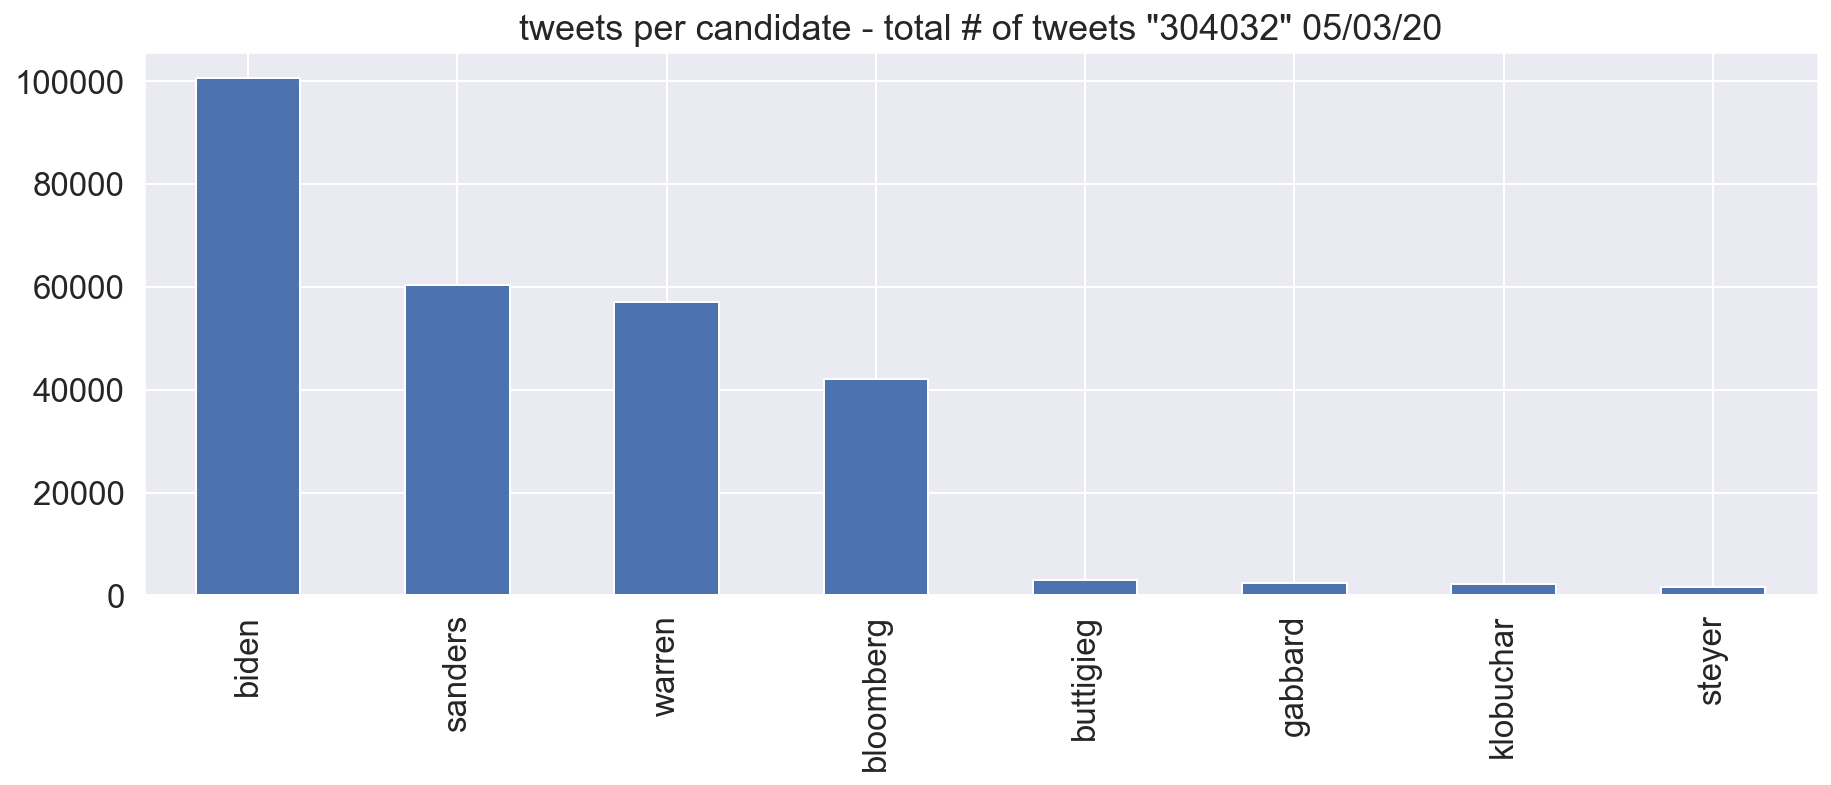

In [45]:
tweets.keyword.value_counts().plot(kind='bar', figsize=(15, 5));
plt.title('tweets per candidate - total # of tweets "304032" 05/03/20');

In [46]:
tweets= tweets.set_index('date')

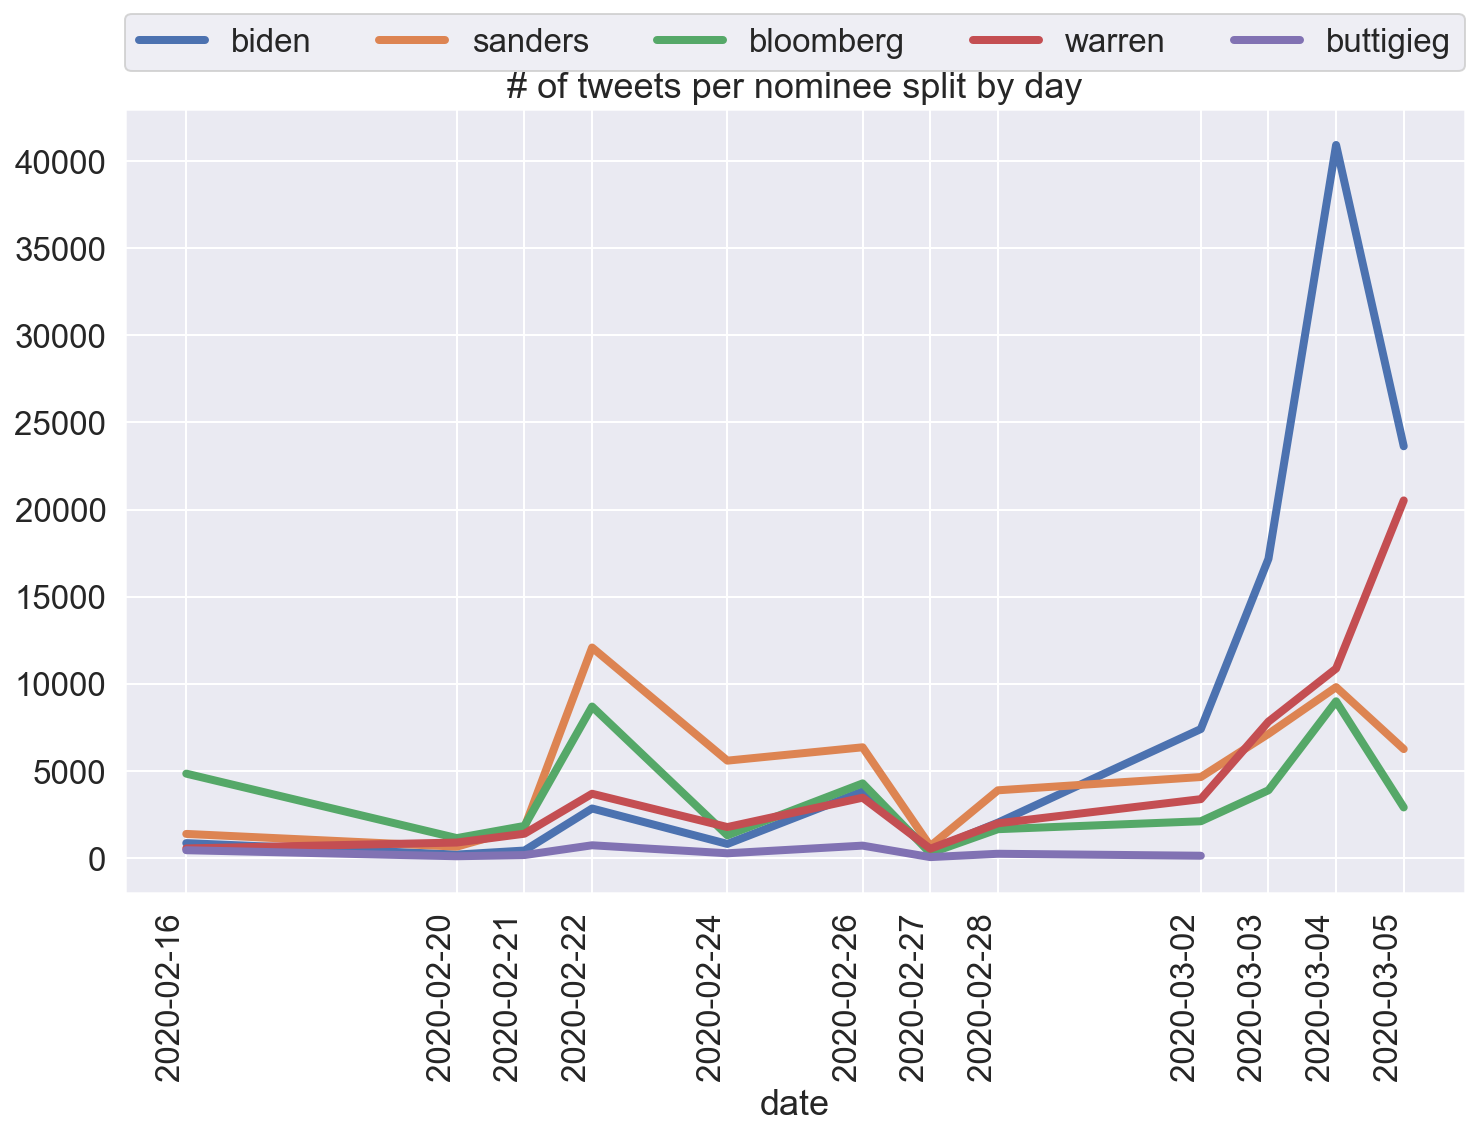

In [47]:
for key in ['biden', 'sanders',  'bloomberg', 'warren', 'buttigieg']:
    tweets[tweets['keyword'] == key].groupby('date').size().plot(figsize=(12, 8), 
                                                                                   label = key, linewidth=4)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
           ncol=8, mode="expand", borderaxespad=0);
plt.xticks(tweets.index.unique(), rotation=90);
plt.title('# of tweets per nominee split by day');

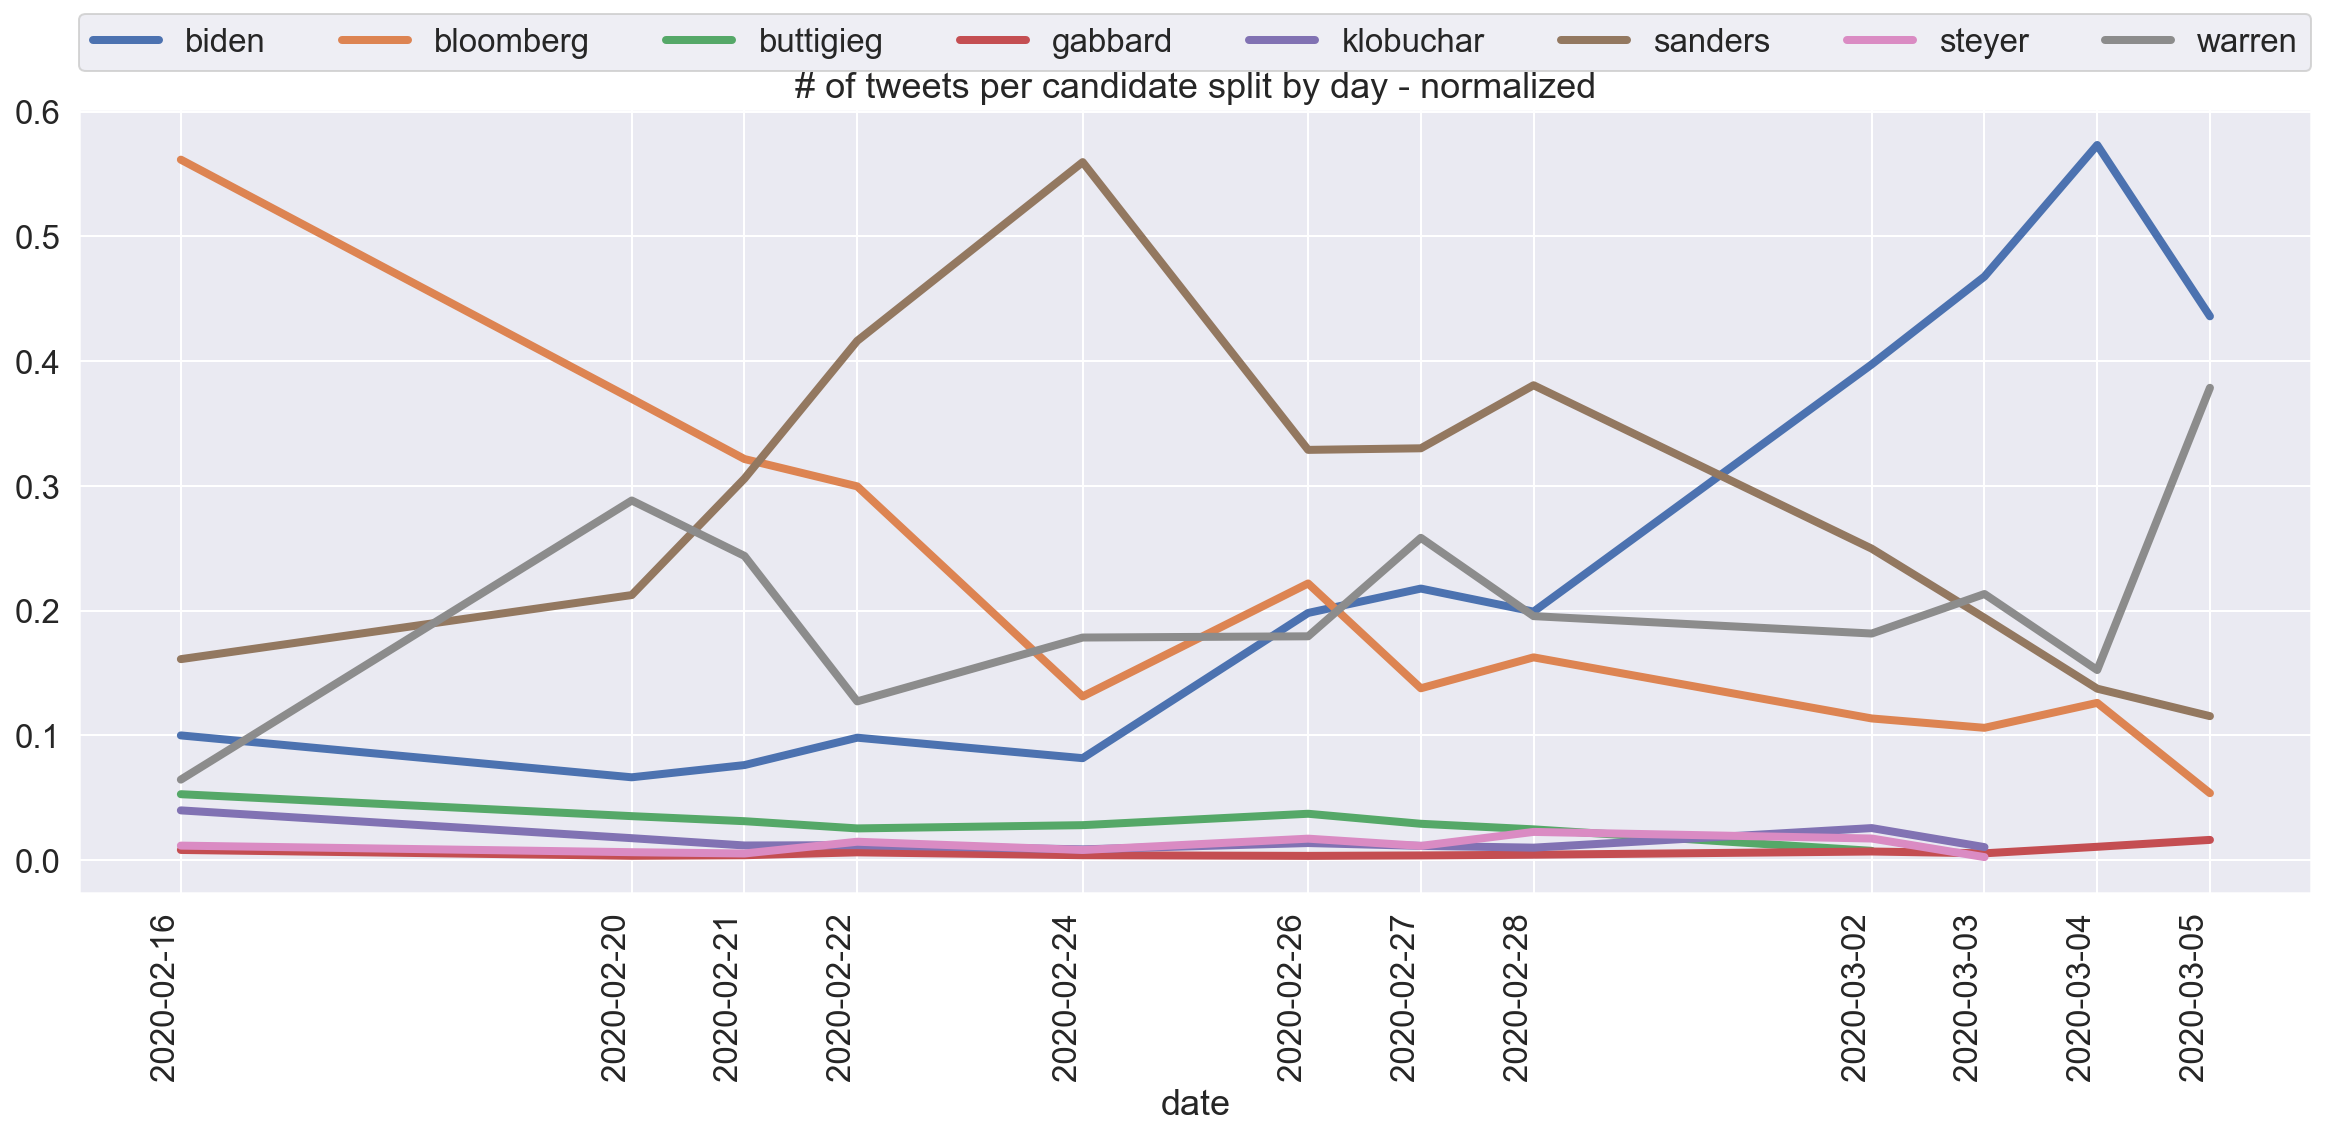

In [48]:
tweets.groupby('date')['keyword'].value_counts(normalize=True).unstack().plot(figsize=(20, 8), 
                                                                              label = tweets.keyword, linewidth=4);
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=8, mode="expand", borderaxespad=0);
plt.xticks(tweets.index.unique(), rotation=90);
plt.title('# of tweets per candidate split by day - normalized');

<style>/n</style>

<style>/n</style>

#### Assigning Scores

In [49]:
def scorer(parsed):
    
    obj_scores, pvn_scores = [], []
    
    for token in parsed:
        try:
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
    
    if not obj_scores:
        obj_scores = [1.]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [50]:
scores = tweets['tokenised_title'].map(scorer)
tweets['objectivity_avg'] = scores.map(lambda x: x[0])
tweets['polarity_avg'] = scores.map(lambda x: x[1])

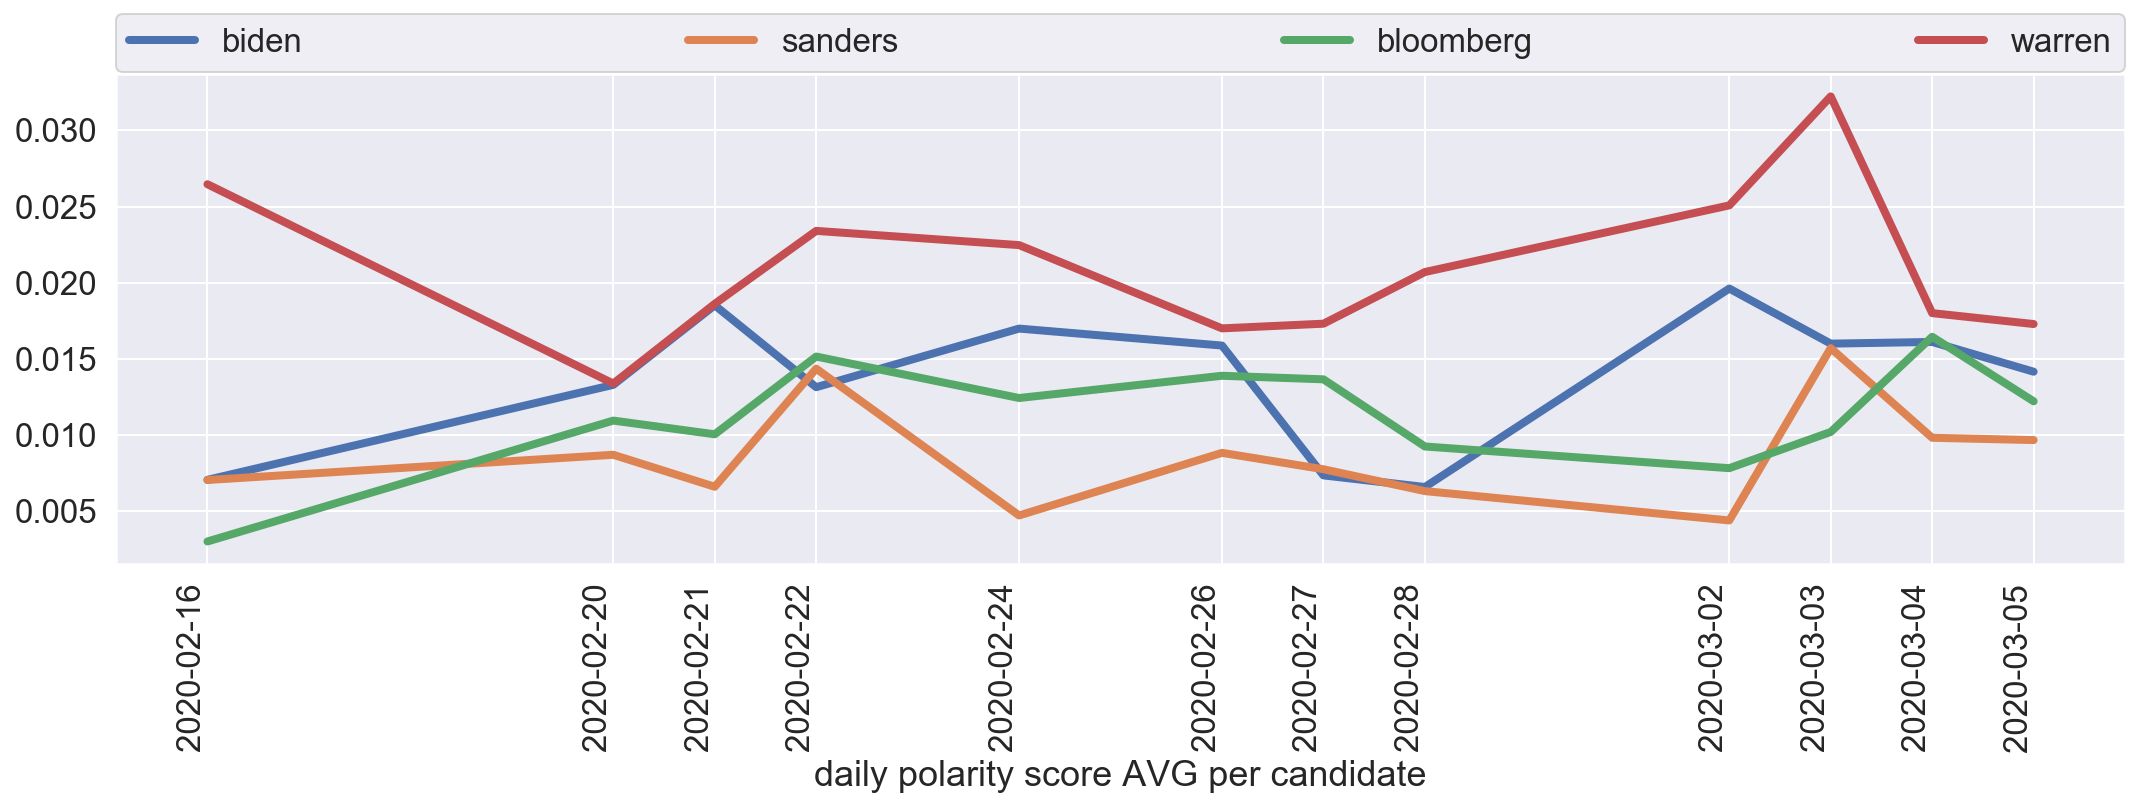

In [52]:
# for key in tweets_ts.keyword.unique():
for key in ['biden', 'sanders','bloomberg', 'warren']:
    tweets[tweets['keyword'] == key].groupby('date')['polarity_avg'].mean().plot(figsize=(18, 5), 
                                                                                   label = key, linewidth=4)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
           ncol=8, mode="expand", borderaxespad=0);
plt.xticks(tweets.index.unique(), rotation=90);
plt.xlabel('daily polarity score AVG per candidate');

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

#### Vader Sentiment Analysis

In [53]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [54]:
analyzer = SentimentIntensityAnalyzer()
for tweet in tweets.tweet:
    vs = analyzer.polarity_scores(tweet)
#     print(tweet)
#     print(vs)

In [55]:
vader_scores = tweets['tweet'].map(analyzer.polarity_scores)

In [56]:
neg=[]
neu=[]
pos =[]
compound=[]
for row in vader_scores.iteritems():
    for k, v in row[1].items():
        if k == 'neg':
            neg.append(v)
        if k == 'neu':
            neu.append(v)
        if k == 'pos':
            pos.append(v)
        if k == 'compound':
            compound.append(v)
tweets['neg']=neg
tweets['neu']=neu
tweets['pos']=pos
tweets['compound']=compound
            

#### Sentiment Fluctuation

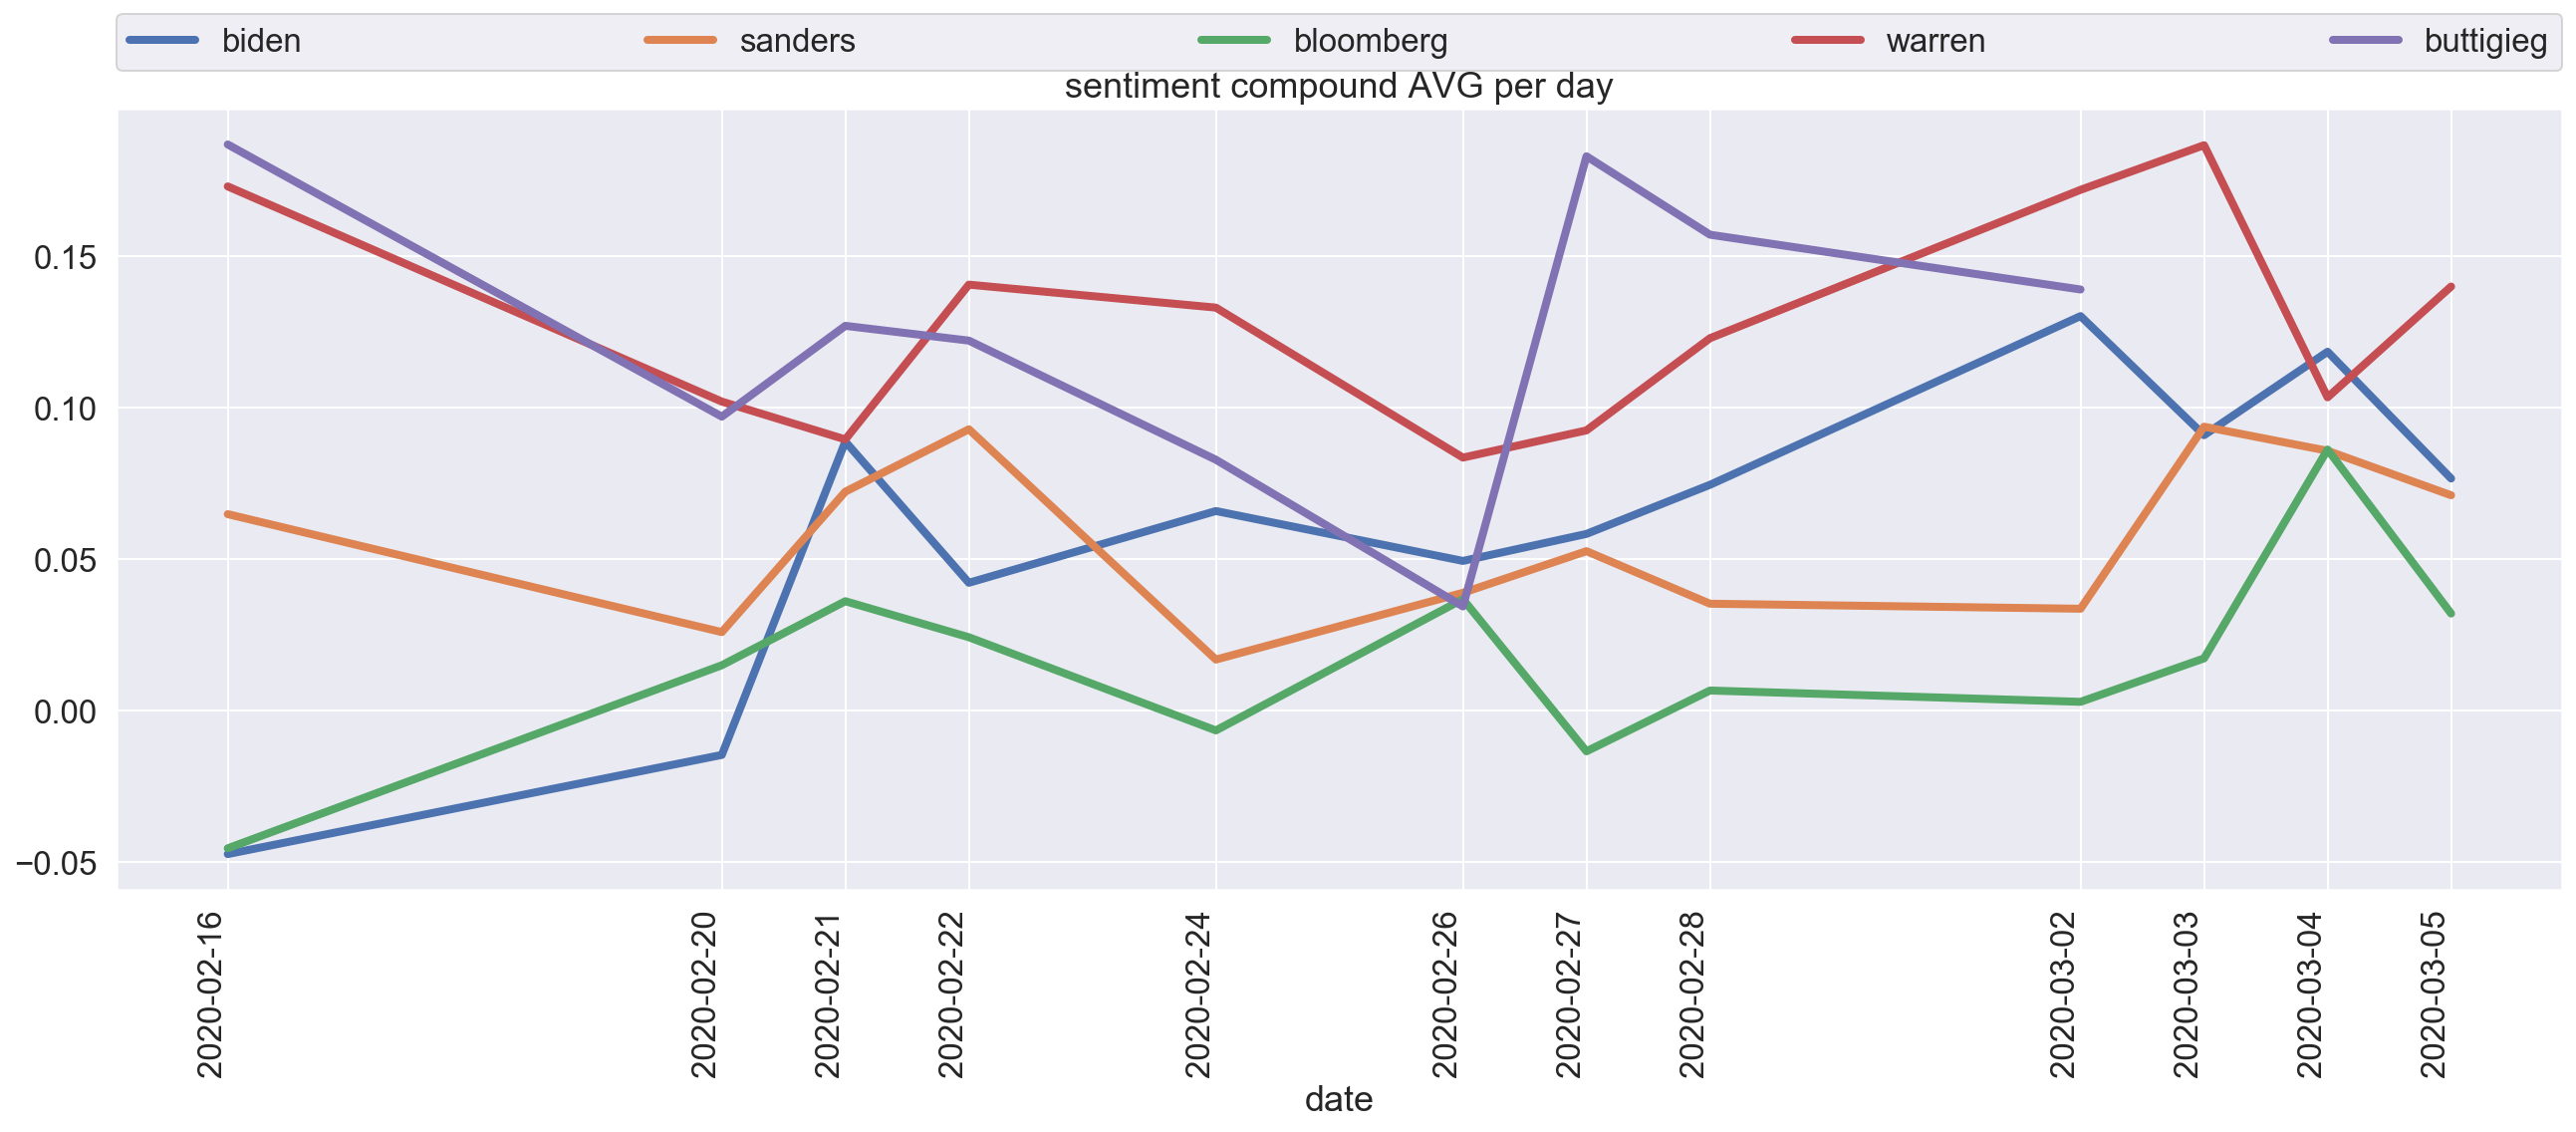

In [57]:
# for key in tweets_ts.keyword.unique():
for key in ['biden', 'sanders','bloomberg', 'warren', 'buttigieg']:
    tweets[tweets['keyword'] == key].groupby('date')['compound'].mean().plot(figsize=(22, 8), 
                                                                                   label = key, linewidth=4)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
           ncol=8, mode="expand", borderaxespad=0);
plt.xticks(tweets.index.unique(), rotation=90);
plt.title('sentiment compound AVG per day');


<style>"/n"</style>

#### Compound Distribution

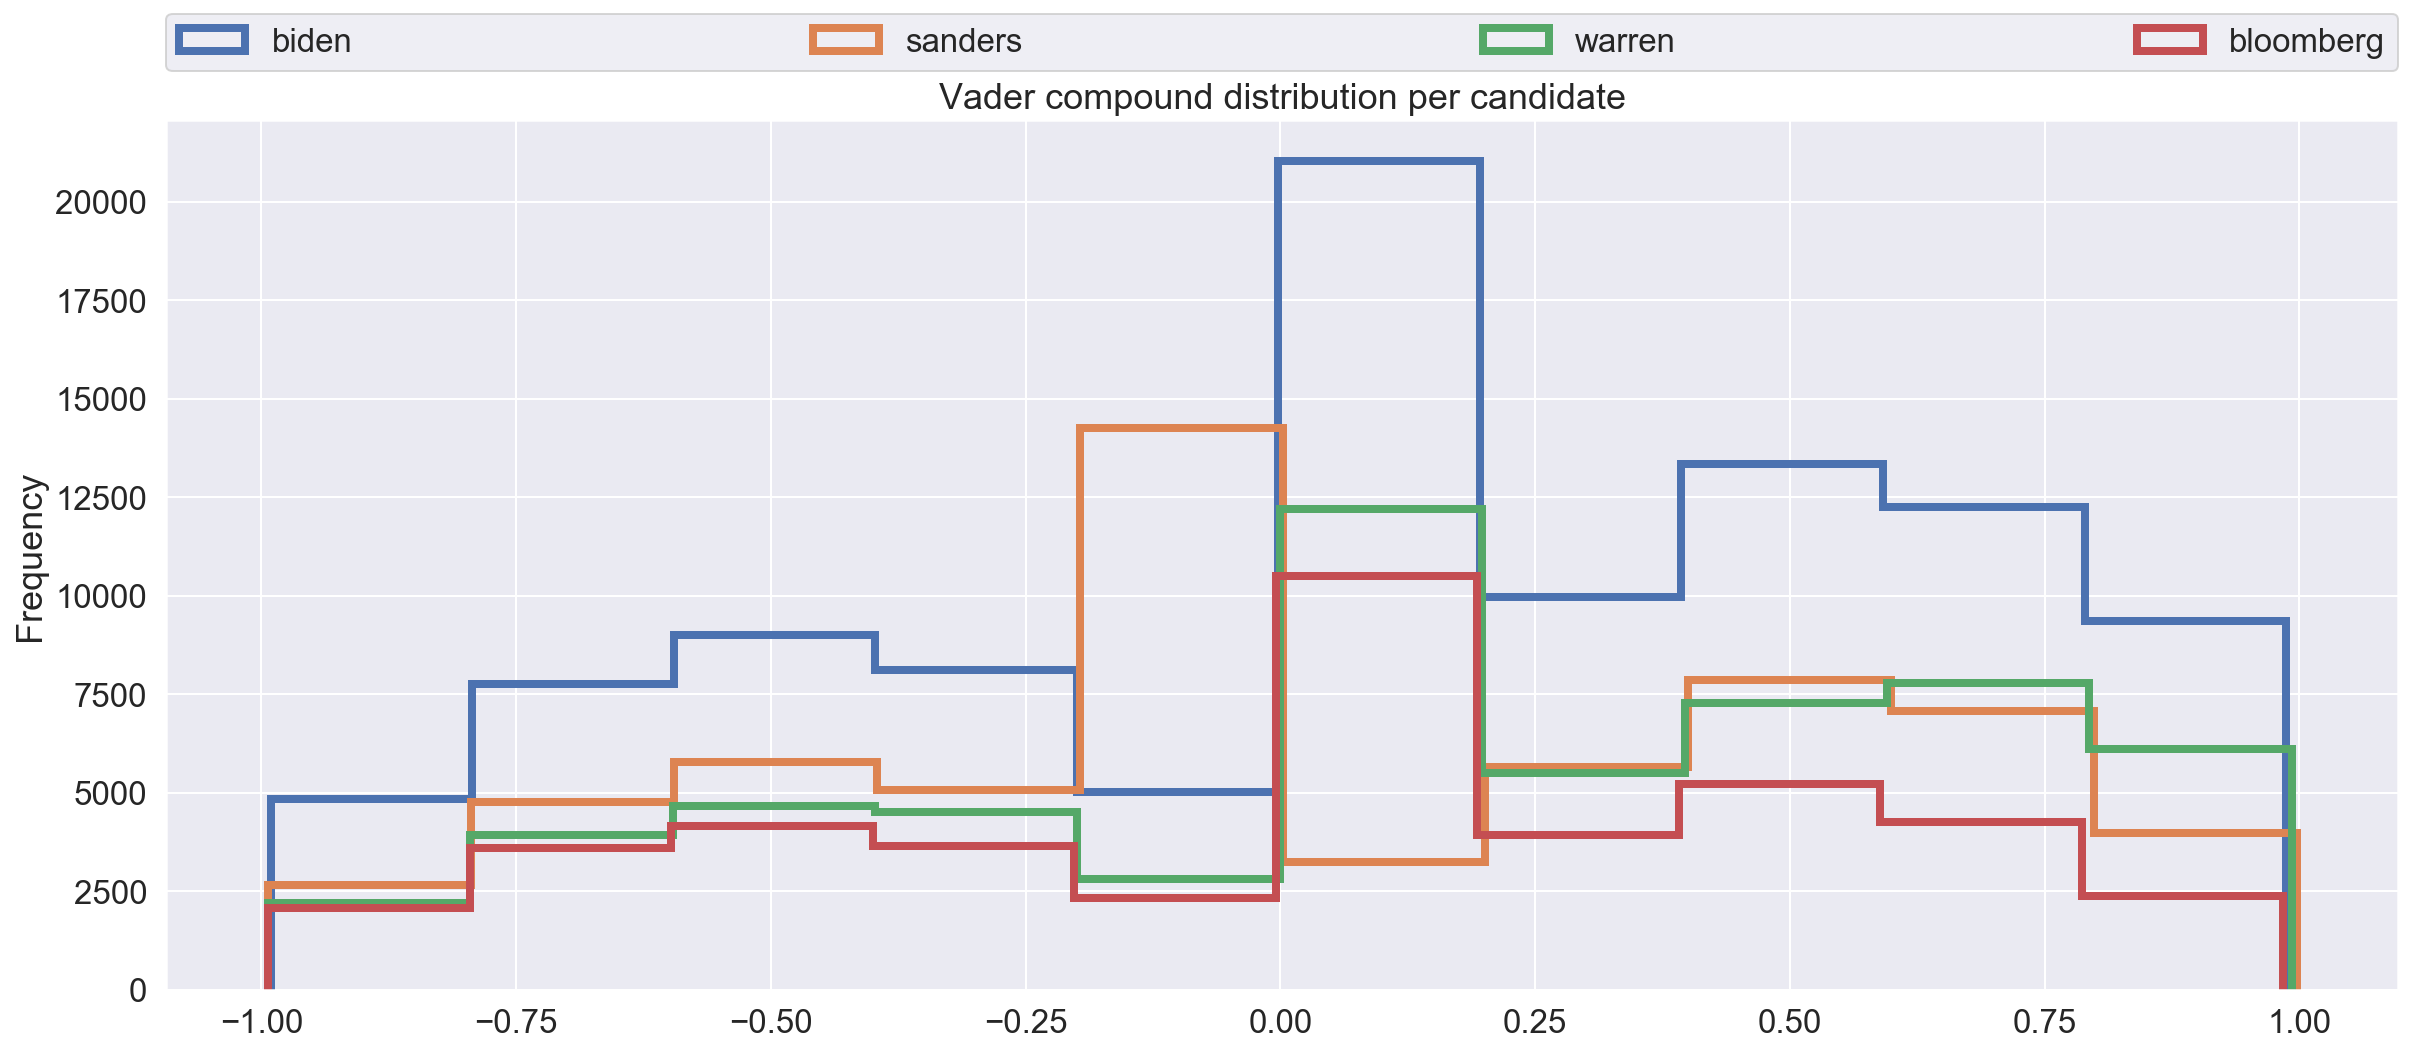

In [59]:
for key in ['biden', 'sanders', 'warren', 'bloomberg']:
    tweets[tweets.keyword == key]['compound'].plot(kind='hist', 
                                        histtype='step', stacked=True, fill=False, label=key, figsize=(20,8), lw=4);
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),
           ncol=8, mode="expand", borderaxespad=0);
plt.title('Vader compound distribution per candidate');

In [140]:
biden=tweets_ts[tweets_ts.keyword == 'biden'].groupby('date')['compound'].mean()
warren =tweets_ts[tweets_ts.keyword == 'warren'].groupby('date')['compound'].mean()
sanders=tweets_ts[tweets_ts.keyword == 'sanders'].groupby('date')['compound'].mean()
bloomberg=tweets_ts[tweets_ts.keyword == 'bloomberg'].groupby('date')['compound'].mean()

In [146]:
biden

date
2020-02-16   -0.044516
2020-02-20   -0.005571
2020-02-21    0.087301
2020-02-22    0.045320
2020-02-24    0.062623
2020-02-26    0.056122
2020-02-27    0.057740
2020-02-28    0.075288
2020-03-02    0.123082
2020-03-03    0.086478
2020-03-04    0.136783
Name: compound, dtype: float64

In [110]:
print(bloomberg.shape, warren.shape, sanders.shape, biden.shape)
print(len(bloomberg), len(warren), len(sanders), len(biden))

(11,) (11,) (11,) (11,)
11 11 11 11


In [142]:
sarima = pd.DataFrame({'biden':biden, 'warren':warren, 'sanders':sanders, 'bloomberg':bloomberg})

In [113]:
model = sm.tsa.statespace.SARIMAX(endog=sarima.biden,
                                  exog=sarima[['sanders', 'warren', 'bloomberg']],
                                  order=(1, 1, 1))
#                                   seasonal_order=(1, 1, 1, 12))
results = model.fit(maxiter=10000)
results.summary()

/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zer

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  biden   No. Observations:                   11
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  20.579
Date:                Thu, 05 Mar 2020   AIC                            -29.158
Time:                        13:22:12   BIC                            -27.342
Sample:                             0   HQIC                           -31.150
                                 - 11                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sanders       -0.1816      1.878     -0.097      0.923      -3.863       3.499
warren         0.1728      1.568      0.110      0.912      -2.900       3.246
bloomberg      0.8174      1.539      0.531      0.595      -2.198       3.833
ar.L1         -0.9574      0.719     -1.332      0.183      -2.366       0.452
ma.L1          0.7127      2.954      0.241      0.809      -5.077       6.502
sigma2         0.0009      0.000      2.146      0.032    7.56e-05       0.002
===================================================================================
Ljung-Box (Q):                       10.54   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.31   Prob(JB):                         0.17
Heteroskedasticity (H):               0.19   Skew:                             1.27
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
results.predict(start=5, end=len(sarima.biden)+5-1, dynamic=True, exog=sarima[['sanders', 'warren', 'bloomberg']].values[0:5, :])

/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


5     0.052947
6     0.047021
7     0.032835
8     0.076468
9     0.038919
10    0.125060
11    0.000059
12    0.069209
13    0.048165
14    0.073723
15    0.034315
dtype: float64

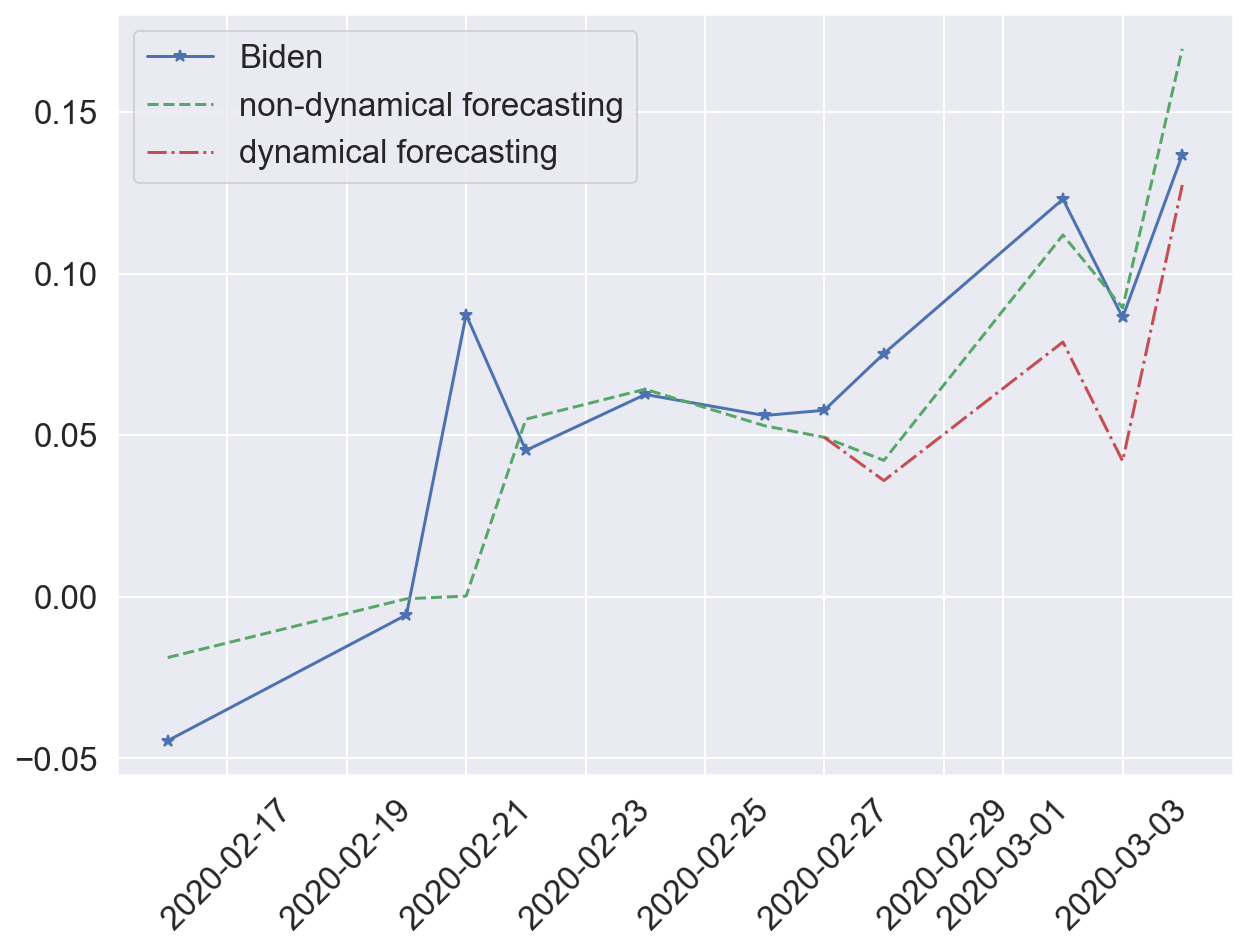

In [115]:
start_p = 5

preds = results.predict(start=0, end=len(sarima.biden)-1, dynamic=False)
preds_dyn = results.predict(start=len(sarima.biden)-start_p,
                            end=len(sarima.biden)-1, dynamic=True)
fcast = pd.concat([sarima.biden, preds])
fcast_1 = pd.concat([sarima.biden[:len(sarima.biden)-1-start_p], preds_dyn])


plt.figure(figsize=(10,7))
plt.plot(sarima.biden, 'b*-', preds, 'g--', preds_dyn, 'r-.')
plt.xticks(rotation=45)
plt.legend(['Biden', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

<style>"/n"</style>

#### Real Clear Politics National Polls for the same period

In [62]:
polls=pd.read_csv('polls.csv')
polls

,Candidates,16/02/20,17/02/20,18/02/20,19/02/20,20/02/20,21/02/20,22/02/20,23/02/20,24/02/20,25/02/20,26/02/20,27/02/20,28/02/20,29/02/20,1/03/20,2/03/20,3/03/20,4/03/20,5/03/20
0,Sanders,24.8,25.6,27.3,27.8,28.6,28.7,28.7,29.3,29.2,28.8,29.2,29.5,29.5,29.6,28.5,28.5,26.0,26.0,26.8
1,Biden,17.8,18.0,16.5,17.8,17.6,17.3,17.3,17.2,17.0,17.4,18.0,18.0,18.4,18.8,19.0,20.0,24.6,27.5,34.3
2,Bloomberg,14.6,15.2,15.8,16.1,15.9,15.2,15.2,15.3,15.5,14.8,14.4,14.7,15.5,16.4,15.8,15.0,16.2,16.7,NaN
3,Warren,12.6,11.8,12.8,12.3,12.3,12.7,12.7,13.2,12.8,13.0,12.4,12.0,12.1,11.8,12.7,14.0,14.0,13.5,13.8
4,Buttigieg,10.0,10.4,10.8,10.3,10.3,10.0,10.0,9.8,9.8,10.2,10.0,10.3,10.5,11.0,10.3,9.8,9.0,NaN,NaN
5,Klobuchar,5.8,5.8,6.8,6.4,6.6,6.7,6.7,6.3,6.2,5.6,5.4,5.3,5.0,4.0,4.3,4.8,4.7,NaN,NaN
6,Steyer,1.6,1.8,1.8,2.4,2.3,2.2,2.2,2.2,2.3,2.4,2.4,2.2,2.5,2.6,2.6,2.3,2.0,NaN,NaN
7,Gabbard,1.4,1.5,1.7,1.4,1.7,1.6,1.6,1.4,1.5,1.8,2.2,2.2,1.6,1.4,1.4,1.3,1.3,NaN,NaN


In [63]:
polls=polls.set_index('Candidates', drop=True)

In [64]:
polls_t=polls.T
polls_t

Candidates,Sanders,Biden,Bloomberg,Warren,Buttigieg,Klobuchar,Steyer,Gabbard
16/02/20,24.8,17.8,14.6,12.6,10.0,5.8,1.6,1.4
17/02/20,25.6,18.0,15.2,11.8,10.4,5.8,1.8,1.5
18/02/20,27.3,16.5,15.8,12.8,10.8,6.8,1.8,1.7
19/02/20,27.8,17.8,16.1,12.3,10.3,6.4,2.4,1.4
20/02/20,28.6,17.6,15.9,12.3,10.3,6.6,2.3,1.7
21/02/20,28.7,17.3,15.2,12.7,10.0,6.7,2.2,1.6
22/02/20,28.7,17.3,15.2,12.7,10.0,6.7,2.2,1.6
23/02/20,29.3,17.2,15.3,13.2,9.8,6.3,2.2,1.4
24/02/20,29.2,17.0,15.5,12.8,9.8,6.2,2.3,1.5
25/02/20,28.8,17.4,14.8,13.0,10.2,5.6,2.4,1.8


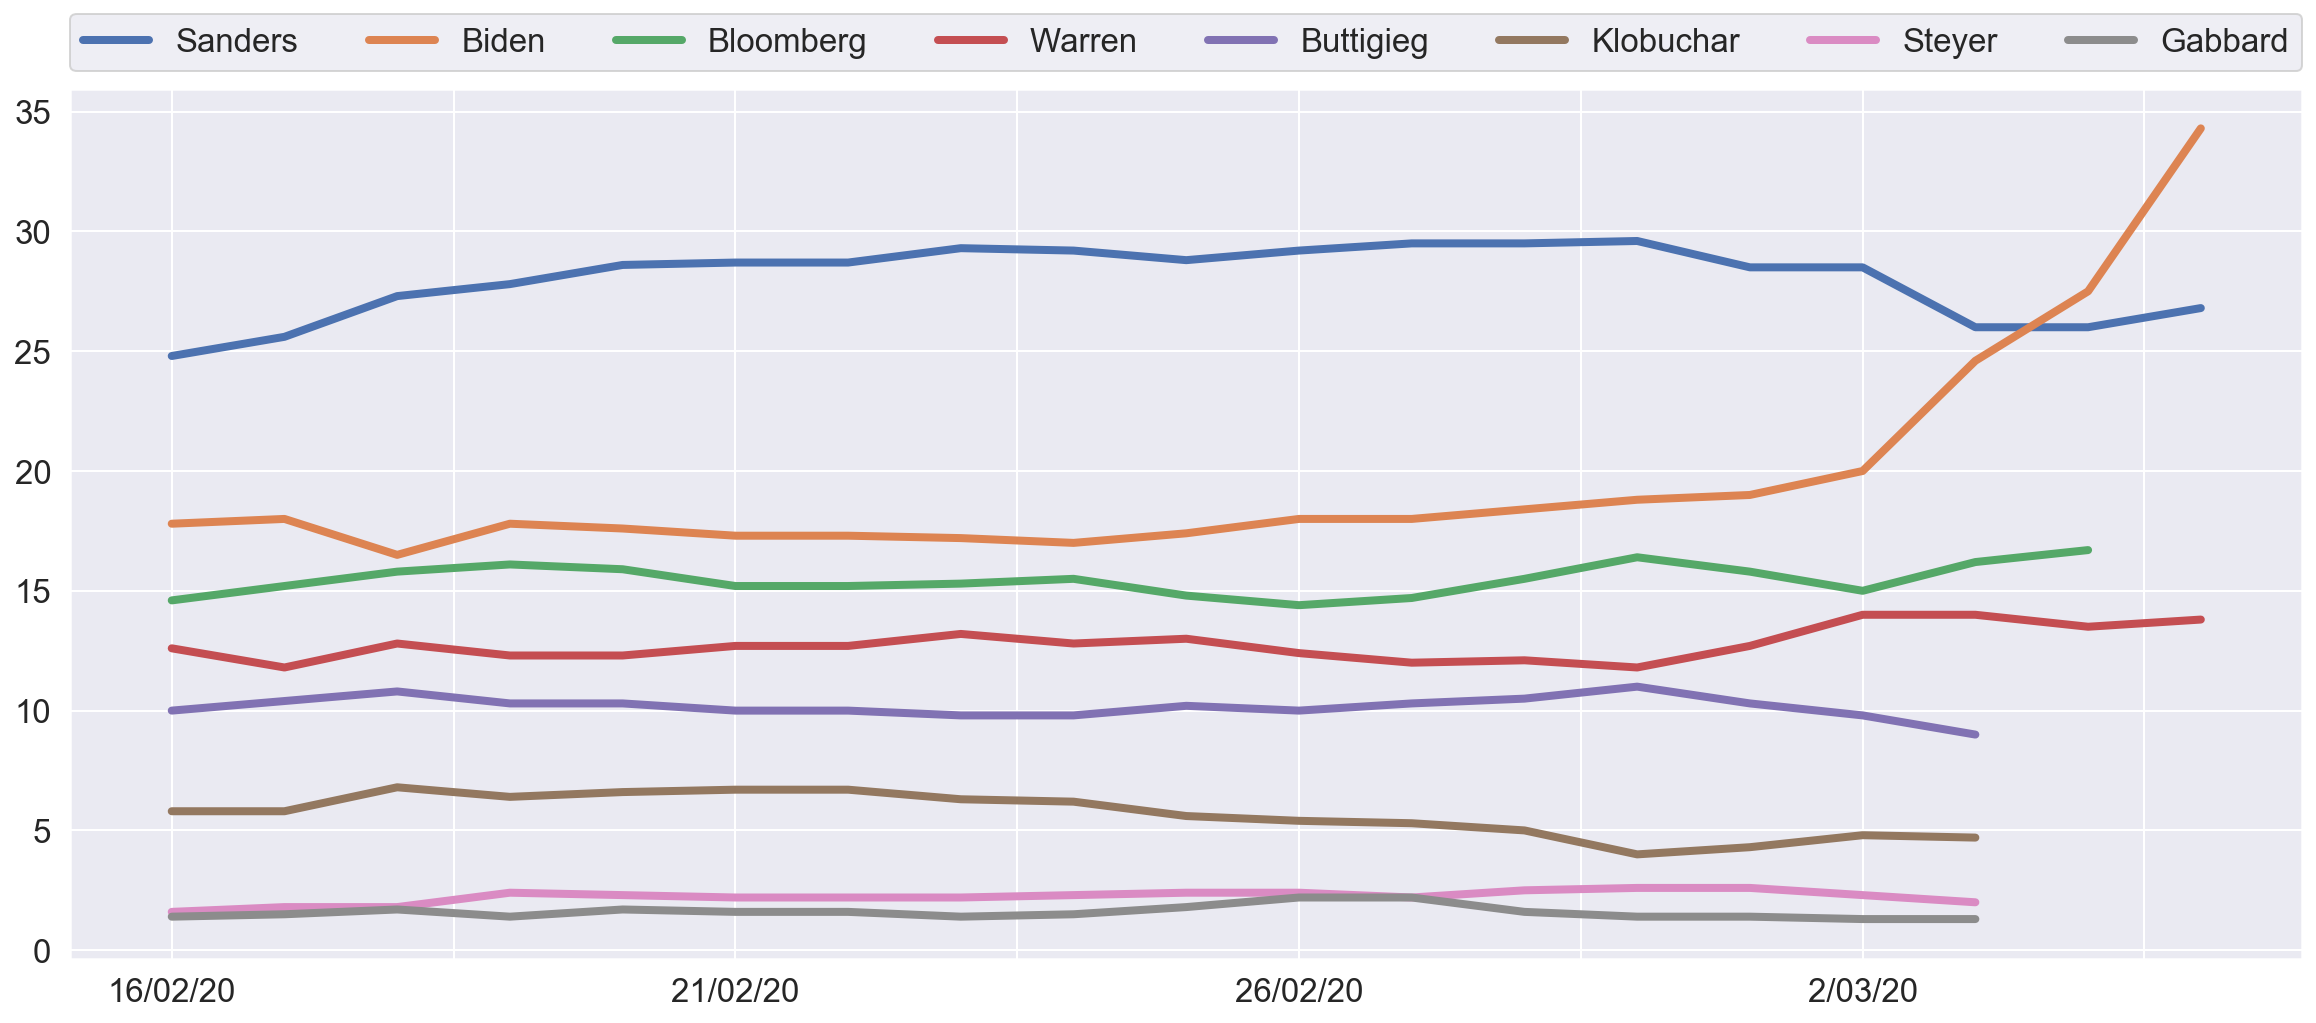

In [65]:
polls_t.plot(figsize=(20, 8), label= 'Candidates', linewidth=4)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=8, mode="expand", borderaxespad=0);


# <style> /n </style>

<style> /n </style>

#### Function which identifies hashtags

In [ ]:
# hashtags= []
# for tweet in tweets.tweet:
#     hashtag=re.findall(r'(^#(\w+))', tweet)
#     if len(hashtag) >0:
#         hashtags.append(hashtag)

# for i, h in enumerate(hashtags, 1):
#     print(i,h)